In [1]:
import pandas as pd
import xarray as xr
import numpy as np

In [2]:
import datetime

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [4]:
path_data = 'C:/Users/Alberto/Desktop/Crypto prediction/Data/'
data_file_name = 'btcusd.csv'
data = pd.read_csv(path_data + data_file_name)

In [5]:
data.head()

,time,open,close,high,low,volume
0,1364774820000,93.25,93.30,93.30,93.25,93.300000
1,1364774880000,100.00,100.00,100.00,100.00,93.300000
2,1364774940000,93.30,93.30,93.30,93.30,33.676862
3,1364775060000,93.35,93.47,93.47,93.35,20.000000
4,1364775120000,93.47,93.47,93.47,93.47,2.021627


### Index time

In [6]:
def from_unix_to_datetime(unix_time):
    return datetime.datetime.fromtimestamp(int(unix_time))

In [7]:
def to_str(element):
    return str(element)[:10]

In [8]:
data['Time'] = data['time'].apply(to_str).apply(from_unix_to_datetime)

In [9]:
data.pop('time')

0          1364774820000
1          1364774880000
2          1364774940000
3          1364775060000
4          1364775120000
               ...      
3245591    1615388760000
3245592    1615388820000
3245593    1615388880000
3245594    1615388940000
3245595    1615389000000
Name: time, Length: 3245596, dtype: int64

In [10]:
data.set_index(data['Time'], drop=True, inplace=True)

In [11]:
data.pop('Time')

Time
2013-04-01 02:07:00   2013-04-01 02:07:00
2013-04-01 02:08:00   2013-04-01 02:08:00
2013-04-01 02:09:00   2013-04-01 02:09:00
2013-04-01 02:11:00   2013-04-01 02:11:00
2013-04-01 02:12:00   2013-04-01 02:12:00
                              ...        
2021-03-10 16:06:00   2021-03-10 16:06:00
2021-03-10 16:07:00   2021-03-10 16:07:00
2021-03-10 16:08:00   2021-03-10 16:08:00
2021-03-10 16:09:00   2021-03-10 16:09:00
2021-03-10 16:10:00   2021-03-10 16:10:00
Name: Time, Length: 3245596, dtype: datetime64[ns]

### Data exploration

In [12]:
data.describe()

,open,close,high,low,volume
count,3.245596e+06,3.245596e+06,3.245596e+06,3.245596e+06,3.245596e+06
mean,6.191089e+03,6.191097e+03,6.194570e+03,6.187574e+03,1.769986e+01
std,7.950879e+03,7.950914e+03,7.957110e+03,7.944559e+03,5.955338e+01
min,1.000000e-02,1.060000e+00,1.060000e+00,1.000000e-02,1.000000e-08
25%,6.092800e+02,6.092800e+02,6.095300e+02,6.090100e+02,5.537165e-01
50%,4.305028e+03,4.305000e+03,4.307300e+03,4.302600e+03,3.185655e+00
75%,8.882000e+03,8.882100e+03,8.886500e+03,8.878400e+03,1.337075e+01
max,5.831700e+04,5.831700e+04,5.832124e+04,5.830400e+04,7.228079e+03


In [13]:
data.corr()

,open,close,high,low,volume
open,1.000000,0.999998,0.999999,0.999999,-0.047487
close,0.999998,1.000000,0.999999,0.999999,-0.047516
high,0.999999,0.999999,1.000000,0.999998,-0.047226
low,0.999999,0.999999,0.999998,1.000000,-0.047796
volume,-0.047487,-0.047516,-0.047226,-0.047796,1.000000


In [14]:
#sns.heatmap(data.corr())

### Plots

#### Select 2020 data

In [15]:
year = 2020

time_condition = data.index.year == year
df = data[time_condition]

#### Resample to 30 mins data

In [16]:
df = df.resample('30T').mean()

Text(0, 0.5, 'Close price [$]')

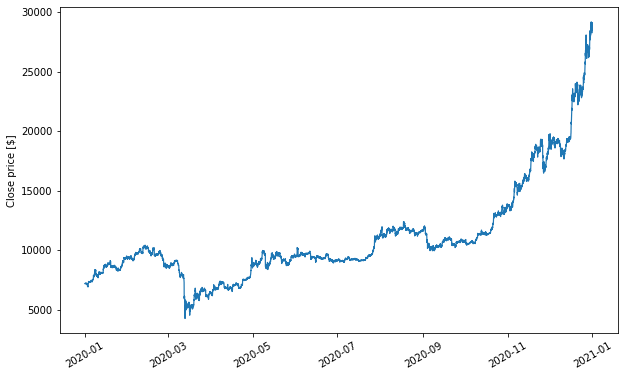

In [17]:
path_fig = 'C:/Users/Alberto/Desktop/Crypto prediction/Representations/btcusd/'

plt.figure(figsize=(10,6))

plt.plot(df.index, df['close'], linewidth=1.2, label='btc/usd')
plt.xticks(rotation='30')
plt.ylabel('Close price [$]')
#plt.savefig(path_fig + 'btc_close_2020.png')

### Define some indicators

#### Simple moving average (SMA)

In [18]:
df['sma_3h'] = df['close'].rolling(window='3h', center=False, min_periods=6).mean()

In [19]:
df['sma_6h'] = df['close'].rolling(window='6h', center=False, min_periods=12).mean()

In [20]:
df['sma_24h'] = df['close'].rolling(window='24h', center=False, min_periods=48).mean()

#### Exponential moving average (EMA)

In [21]:
df['ema_6h'] = df['close'].ewm(span=12, min_periods=12).mean()

#### Relative strenght index (RSI)

In [22]:
"""
Definition:
==========================================================

UNITS_OF_TIME = 12   # this value is tipically 14
RS = AVG_GAINS(UNITS_OF_TIME) / AVG_LOSSES(UNITS_OF_TIME)

RSI = 100 - 100 / (1 + RS)
"""
def diff(array):
    return array[1] - array[0]

def is_gain(array):
    return array > 0

def rsi_metric(array):
    if len(array) == 0:
        return np.nan
    else:
        gains = array[is_gain(array)]
        losses = array[is_gain(array) == False]
    
        len_gains = len(gains)
        len_losses = len(losses)
        
        if len_gains == 0:
            return 0
        else:
            exp_decay = np.exp(- np.arange(1, len_gains + 1 , 1) / len_gains)
            avg_gains = np.abs(np.mean(gains * exp_decay))
        
        if len_losses == 0:
            return 100
        else:
            exp_decay = np.exp(- np.arange(1, len_losses + 1, 1) / len_gains)
            avg_losses = np.abs(np.mean(losses * exp_decay))        
        
        rs = avg_gains / avg_losses
    
        return 100 - 100 / (1 + rs)

# close_variation
df['close_variation'] = df['close'].rolling(window=2, min_periods=2).apply(diff, raw=True)

# rsi
df['rsi'] = df['close_variation'].rolling(window=12, min_periods=12).apply(rsi_metric, raw=True)

#### KDJ

In [23]:
"""
For this indicator we need three lines: K, D and J.
Definition:
==========================================================
UNITS_OF_TIME = 12

lowest_price_list = # list of the lowest value in each win of UNITS_OF_TIME elements
highest_price_list = # list of the highest value in each win of UNITS_OF_TIME elements

rsv = (closing_price - lowest_price_list) / (highest_price_list - lowest_price_list)

K = # exponentially weighted moving average over rsv with center of mass (com) equals to 2
D = # exponentially weighted moving average over K with center of mass (com) equals to 2
J = 3 * K - 2 * D
"""
UNITS_OF_TIME = 12

lowest_price_list = df['low'].rolling(UNITS_OF_TIME, min_periods=UNITS_OF_TIME).min()
lowest_price_list.fillna(value = df['low'].expanding().min(), inplace = True)

highest_price_list = df['high'].rolling(UNITS_OF_TIME, min_periods=UNITS_OF_TIME).max()
highest_price_list.fillna(value = df['high'].expanding().max(), inplace = True)

rsv = (df['close'] - lowest_price_list) / (highest_price_list - lowest_price_list) * 100

df['K'] = pd.Series(rsv).ewm(com=2).mean()
df['D'] = df['K'].ewm(com=2).mean()
df['J'] = 3 * df['K'] - 2 * df['D']

##### Select one day data

In [49]:
df_day = df[df.index.date == datetime.date(2020, 7, 23)]

In [50]:
date = df_day.index.date[0].strftime("%Y/%m/%d")

#### Find overbought and oversold area limits in the selected period of time

In [51]:
"""
Overbought area: K > 80, D > 70, J > 90
Oversold area: K < 20, D < 30
"""

overbought_condition = (df_day['K'] > 80) & (df_day['D'] > 70) & (df_day['J'] > 90)
oversold_condition = (df_day['K'] < 20) & (df_day['D'] < 30)
    
def lims(array):
    lims = [[0,0]]
    for idx, value in enumerate(array):
        if (value == True) & (idx > lims[-1][-1]):
            index = idx + 1
            while index <= (len(array) - 1):
                if array[index] == True:
                    index += 1
                else:
                    break
            if idx < (index - 1):
                lims.append([idx, index-1])

    return lims[1:]

# Indexes of overbought and oversold limit areas
ob_lims_id = lims(overbought_condition.values)
os_lims_id = lims(oversold_condition.values)

# Time of overbought and oversold limit areas
ob_in_interval = df_day.index.values[np.isin(np.arange(len(df_day)), ob_lims_id)]
os_in_interval = df_day.index.values[np.isin(np.arange(len(df_day)), os_lims_id)]

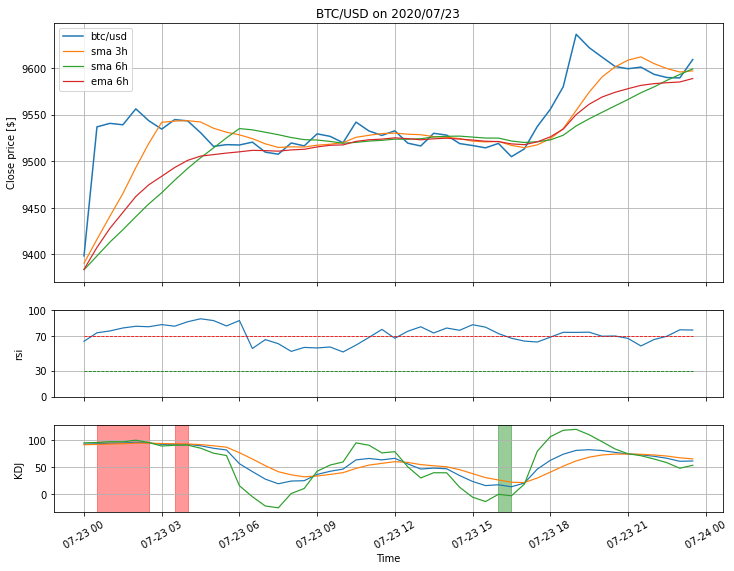

In [52]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12,9), gridspec_kw={'height_ratios': [3, 1, 1]})

plt.xticks(rotation='30')

# Plot BTC/USD graph and indicators: sma, ema
axes[0].plot(df_day.index, df_day['close'], linewidth=1.5, label='btc/usd')
axes[0].plot(df_day.index, df_day['sma_3h'], linewidth=1.2, label='sma 3h')
axes[0].plot(df_day.index, df_day['sma_6h'], linewidth=1.2, label='sma 6h')
axes[0].plot(df_day.index, df_day['ema_6h'], linewidth=1.2, label='ema 6h')
axes[0].legend()
axes[0].set_ylabel('Close price [$]')
axes[0].set_title(f'BTC/USD on {date}')
axes[0].grid()

# Plot indicator: rsi
axes[1].plot(df_day.index, df_day['rsi'], linewidth=1.2, label='rsi')
axes[1].plot(df_day.index, [70] * len(df_day.index), 'r--', linewidth=0.8, label='overbought')
axes[1].plot(df_day.index, [30] * len(df_day.index), 'g--', linewidth=0.8, label='oversold')
axes[1].set_ylabel('rsi')
axes[1].set_ylim([0,100])
axes[1].set_yticks([0, 30, 70, 100])
axes[1].grid()

# Plot indicator: KDJ and overbought and oversold areas
axes[2].plot(df_day.index, df_day['K'], linewidth=1.2, label='K')
axes[2].plot(df_day.index, df_day['D'], linewidth=1.2, label='D')
axes[2].plot(df_day.index, df_day['J'], linewidth=1.2, label='J')
axes[2].set_ylabel('KDJ')
axes[2].set_xlabel('Time')
#axes[2].legend()
for lim in range(len(ob_in_interval)):
    if (lim % 2 == 0) & ((lim + 1) < (len(ob_in_interval))):
        axes[2].axvspan(ob_in_interval[lim], ob_in_interval[lim+1], color='red', alpha=0.4)
for lim in range(len(os_in_interval)):
    if (lim % 2 == 0) & ((lim + 1) < (len(os_in_interval))):
        axes[2].axvspan(os_in_interval[lim], os_in_interval[lim+1], color='green', alpha=0.4)
        
axes[2].grid()

plt.savefig(path_fig + 'btcusd_indicators.png')